In [1]:
import re
import json
from glob import glob
import os
from io import StringIO
from itertools import groupby
import html2text
import pickle

import numpy as np
import bs4
%matplotlib inline
import matplotlib.pyplot as plt

import spacy
sp = spacy.load('en_core_web_sm')

from collections import Counter

In [2]:
import sys
# Ensure that your kernel is using Python3
assert sys.version_info.major == 3

In [3]:
with open('../sample_data.json', 'r') as f:
    data_dict = json.load(f)['data']

In [4]:
h = html2text.HTML2Text()
h.ignore_links = True

data_dict is a list of 100 posts

each post is a dictionary with the following keys:

 'folders', 'nr', 'data', 'created', 'bucket_order', 'no_answer_followup', 
 'change_log', 'bucket_name', 'history', 'type', 'tags', 'tag_good', 'unique_views', 
 'children', 'tag_good_arr', 'id', 'config', 'status', 'request_instructor', 
 'request_instructor_me', 'bookmarked', 'num_favorites', 'my_favorite', 'is_bookmarked', 
 'is_tag_good', 'q_edits', 'i_edits', 's_edits', 't', 'default_anonymity'

ADD MEANING OF EACH OF THE KEYS ABOVE
nr - unique post number used in url


Converting to a super simple data structure with very little remaining info.
Here is the layout of the data structure:

{nr:

   folders: [],
   
   question: "",
   
   s_answer: "",
   
   i_answer: "" }

In [5]:
simple_dict = {}
all_folders = Counter()
processed_simple_dict = {}
all_folders_lst = []


for post in data_dict:
    post_id = post['nr']
    folders = post['folders']
    subject = post['history'][0]['subject']
    question = post['history'][0]['content']
    s_answer = ""
    i_answer = ""
    followups = ""
    all_folders_lst.extend(folders)
    for answer in post['children']:
        if answer['type'] == "i_answer":
            i_answer = answer['history'][0]['content']
        elif answer['type'] == "s_answer":
            s_answer = answer['history'][0]['content']
        elif answer['type'] == "followup": 
            followups = answer['subject']
            for fb in answer['children']:
                followups += fb['subject']
    simple_dict[post_id] = {"folders": folders, "subject":subject,"question": question, "s_answer": s_answer, "i_answer": i_answer, "followups":followups}
    processed_simple_dict[post_id] = {"folders": folders,"subject":h.handle(subject).replace("\n","") ,"question": h.handle(question).replace("\n", ""), 
                            "s_answer": h.handle(s_answer).replace("\n", ""), 
                            "i_answer": h.handle(i_answer).replace("\n", ""),
                            "followups":h.handle(followups).replace("\n","")}
    
all_folders = Counter(all_folders_lst)

In [6]:
print(h.handle("<p>Hello, <a href='https://www.google.com/earth/'>world</a>!"))



Hello, world!




In [7]:
def tokenize_w_numbers(text):
    """Returns a list of words that make up the text.
    
    Note: for simplicity, lowercase everything.
    Requirement: Use Regex to satisfy this function
    
    Params: {text: String}
    Returns: List
    """
    # YOUR CODE HERE
    text = text.lower()
    x = re.findall("[a-zA-Z0-9]+",text)
    return x
def tokenize_wo_numbers(text):
    """Returns a list of words that make up the text.
    
    Note: for simplicity, lowercase everything.
    Requirement: Use Regex to satisfy this function
    
    Params: {text: String}
    Returns: List
    """
    # YOUR CODE HERE
    text = text.lower()
    x = re.findall("[a-zA-Z]+",text)
    return x

def tokenize_SpaCy(text):
    """Returns a list of words that make up the text.
    
    Note: for simplicity, lowercase everything.
    Requirement: Use Regex to satisfy this function
    
    Params: {text: String}
    Returns: List
    """
    text = text.lower()
    tokenized = sp(text)    
    return [w.lemma_ for w in tokenized if not w.is_punct and not w.is_stop]

In [8]:
tokenize_w_numbers("It's time 2 get down to the bread-and-butter")

['it', 's', 'time', '2', 'get', 'down', 'to', 'the', 'bread', 'and', 'butter']

In [9]:
tokenize_wo_numbers("It's time 2 get down to the bread-and-butter")

['it', 's', 'time', 'get', 'down', 'to', 'the', 'bread', 'and', 'butter']

In [10]:
tokenize_SpaCy("It's time 2 get down to the bread-and-butter")

['time', '2', 'bread', 'butter']

In [11]:
def tokenize_transcript(tokenize_method,input_transcript):
    """Returns a list of words contained in an entire transcript.
    Params: {tokenize_method: Function (a -> b),
             input_transcript: Tuple}
    Returns: List
    """
    # YOUR CODE HERE
    token_dict = {}
    
    total_tokens = []
    for (k,i) in input_transcript.items():
        token_simpl_dict = {}
        token_simpl_dict['folders'] = i['folders']
        question = tokenize_method(i['question'])
        total_tokens.extend(question)
        token_simpl_dict['question'] = Counter(question)
        i_answer = tokenize_method(i['i_answer'])
        total_tokens.extend(i_answer)
        token_simpl_dict['i_answer'] = Counter(i_answer)
        s_answer = tokenize_method(i['s_answer'])
        total_tokens.extend(s_answer)
        token_simpl_dict['s_answer'] = Counter(s_answer)
        subject = tokenize_method(i['subject'])
        total_tokens.extend(subject)
        token_simpl_dict['subject'] = Counter(subject)
        followups = tokenize_method(i['followups'])
        total_tokens.extend(followups)
        token_simpl_dict['followups'] = Counter(followups)
        token_dict[k] = token_simpl_dict
    return (token_dict, Counter(total_tokens))

In [12]:
(tokenized_spacy_dict, total_tokens_spacy) = tokenize_transcript(tokenize_SpaCy, processed_simple_dict)

In [13]:
(tokenized_num_dict, total_tokens_w_num) = tokenize_transcript(tokenize_w_numbers, processed_simple_dict)

In [14]:
(tokenized_no_num_dict, total_tokens_wo_num) = tokenize_transcript(tokenize_wo_numbers, processed_simple_dict)

In [15]:
processed_simple_dict[505].keys()

dict_keys(['folders', 'subject', 'question', 's_answer', 'i_answer', 'followups'])

In [16]:
tokenized_num_dict[505]

{'folders': ['exam'],
 'followups': Counter({'1': 1,
          '2': 5,
          '3': 4,
          'a': 1,
          'accounted': 1,
          'algorithm': 1,
          'also': 1,
          'and': 2,
          'as': 3,
          'bank': 4,
          'be': 3,
          'because': 1,
          'between': 1,
          'both': 1,
          'completely': 1,
          'correctlycalculated': 1,
          'could': 2,
          'do': 1,
          'documents': 1,
          'explain': 1,
          'financial': 7,
          'for': 1,
          'from': 1,
          'generated': 1,
          'generating': 1,
          'get': 1,
          'gives': 1,
          'how': 2,
          'if': 1,
          'irrelevant': 1,
          'is': 3,
          'it': 2,
          'latter': 1,
          'midpoint': 1,
          'not': 3,
          'ofinformation': 1,
          'pieces': 1,
          'point': 1,
          'problem': 1,
          'query': 1,
          'relevantdocuments': 1,
          'result': 1,
      

In [17]:
tokenized_no_num_dict[505]

{'folders': ['exam'],
 'followups': Counter({'a': 1,
          'accounted': 1,
          'algorithm': 1,
          'also': 1,
          'and': 2,
          'as': 3,
          'bank': 4,
          'be': 3,
          'because': 1,
          'between': 1,
          'both': 1,
          'completely': 1,
          'correctlycalculated': 1,
          'could': 2,
          'do': 1,
          'documents': 1,
          'explain': 1,
          'financial': 7,
          'for': 1,
          'from': 1,
          'generated': 1,
          'generating': 1,
          'get': 1,
          'gives': 1,
          'how': 2,
          'if': 1,
          'irrelevant': 1,
          'is': 3,
          'it': 2,
          'latter': 1,
          'midpoint': 1,
          'not': 3,
          'ofinformation': 1,
          'pieces': 1,
          'point': 1,
          'problem': 1,
          'query': 1,
          'relevantdocuments': 1,
          'result': 1,
          'resulting': 1,
          'rocchio': 2,
          

In [18]:
tokenized_spacy_dict[505]

{'folders': ['exam'],
 'followups': Counter({'1,2': 1,
          '2,3': 4,
          '<': 5,
          '>': 5,
          'account': 1,
          'algorithm': 1,
          'bank': 4,
          'be?the': 1,
          'completely': 1,
          'correctlycalculated': 1,
          'document': 1,
          'explain': 1,
          'financial': 7,
          'generate': 2,
          'gives.how': 1,
          'irrelevant': 1,
          'midpoint': 1,
          'ofinformation': 1,
          'piece': 1,
          'point': 1,
          'problem': 1,
          'query': 1,
          'relevantdocument': 1,
          'result': 2,
          'rocchio': 2,
          'separate': 1,
          'thatcorresponde': 1,
          'theformer': 1,
          'towardsthe': 1,
          'updated': 1,
          'vector': 7,
          'x"s?if': 1}),
 'i_answer': Counter(),
 'question': Counter({'associate': 1,
          'query': 1,
          'rocchio': 1,
          'update': 1,
          'word': 1}),
 's_answer': Count

In [19]:
total_tokens_w_num

Counter({'the': 984,
         'faculty': 2,
         'senate': 1,
         'and': 315,
         'student': 11,
         'assembly': 1,
         'endorsed': 2,
         'following': 9,
         'renewedcommitment': 1,
         'to': 473,
         'academic': 5,
         'integrity': 3,
         'equitable': 2,
         'instructions': 13,
         'honorfinal': 1,
         'pdfall': 1,
         'students': 19,
         'tas': 17,
         'must': 9,
         'review': 3,
         'it': 157,
         'modifications': 2,
         'syllabusdiscussed': 1,
         'in': 267,
         '594': 1,
         'at': 57,
         'this': 158,
         'time': 24,
         'contact': 2,
         'me': 10,
         'directly': 2,
         'via': 12,
         'piazza': 27,
         'private': 6,
         'email': 7,
         'or': 75,
         'oh': 21,
         'if': 118,
         'they': 32,
         'have': 111,
         'any': 42,
         'concerns': 2,
         'thanks': 16,
         'pin': 10,
 

In [20]:
total_tokens_wo_num

Counter({'the': 984,
         'faculty': 2,
         'senate': 1,
         'and': 316,
         'student': 11,
         'assembly': 1,
         'endorsed': 2,
         'following': 9,
         'renewedcommitment': 1,
         'to': 473,
         'academic': 5,
         'integrity': 3,
         'equitable': 2,
         'instructions': 13,
         'honorfinal': 1,
         'pdfall': 1,
         'students': 19,
         'tas': 17,
         'must': 9,
         'review': 3,
         'it': 157,
         'modifications': 2,
         'syllabusdiscussed': 1,
         'in': 267,
         'at': 57,
         'this': 158,
         'time': 24,
         'contact': 2,
         'me': 10,
         'directly': 2,
         'via': 12,
         'piazza': 27,
         'private': 6,
         'email': 7,
         'or': 75,
         'oh': 21,
         'if': 118,
         'they': 32,
         'have': 111,
         'any': 42,
         'concerns': 2,
         'thanks': 17,
         'pin': 10,
         'renewed': 

In [21]:
total_tokens_spacy

Counter({'faculty': 2,
         'senate': 1,
         'student': 28,
         'assembly': 1,
         'endorse': 1,
         'follow': 16,
         'renewedcommitment': 1,
         'academic': 4,
         'integrity': 3,
         'equitable': 2,
         'instruction': 10,
         'honorfinal.pdfall': 1,
         'tas': 17,
         'review': 3,
         'modification': 3,
         'syllabusdiscusse': 1,
         '@594': 1,
         'time': 37,
         'contact': 3,
         'directly': 2,
         'piazza': 25,
         'private': 6,
         'email': 9,
         'oh': 19,
         'concerns.thanks!#pin': 1,
         'renew': 1,
         'commitment': 1,
         'remember': 4,
         'update': 33,
         'hotcrp': 13,
         'submission': 25,
         'foreach': 1,
         'milestone': 12,
         'create': 11,
         'new': 8,
         'instead': 5,
         'beedite': 1,
         'original': 3,
         'receivedan': 1,
         'delete': 3,
         'attach': 3,
      

In [22]:
main_sample_dict_processed = {"tokenized_num_dict":tokenized_num_dict, "tokenized_no_num_dict":tokenized_no_num_dict, "total_tokens_w_num":total_tokens_w_num, "total_tokens_wo_num":total_tokens_wo_num, "tokenized_spacy_dict":tokenized_spacy_dict, "total_tokens_spacy":total_tokens_spacy}

In [23]:
main_sample_dict_processed.keys()

dict_keys(['tokenized_num_dict', 'tokenized_no_num_dict', 'total_tokens_w_num', 'total_tokens_wo_num', 'tokenized_spacy_dict', 'total_tokens_spacy'])

In [24]:
pickle.dump( main_sample_dict_processed, open( "sample_data_preprocessed.p", "wb" ) )

In [25]:
def build_inverted_index(nrs):
    """ Builds an inverted index from the messages."""
    folders = set()
    result = {}
    for nr, nr_dict in nrs.items():
        folder = nr_dict["folders"]
        for word_freq in [nr_dict["question"], nr_dict["s_answer"], nr_dict["i_answer"]]:
            for word, freq in word_freq.items():
                for fold in folder:
                    if fold not in folders:
                        folders.add(fold)
                    if word in result:
                        if fold in result[word]:
                            result[word][fold] += freq
                        else:
                            result[word][fold] = freq
                    else:
                        result[word] = {fold: freq}
    for word, fold_freq in result.items():
        result[word] = list(fold_freq.items())
    return result, folders

In [26]:
#Note: these defaults don't prune any words
def compute_idf(inv_idx, n_docs, min_df=1, max_df_ratio=1.0):
    """ Compute term IDF values from the inverted index.
    Words that are too frequent or too infrequent get pruned."""
    # YOUR CODE HERE
    idf = {}
    max_df = max_df_ratio * n_docs
    for key, value in inv_idx.items():
        df = len(value)
        if df >= min_df and df <= max_df:
            #don't need +1 in denominator because we won't have any empty lists
            idf[key] = round(np.log2(n_docs / df), 2)
    return idf

In [27]:
inv_idx, folders = build_inverted_index(tokenized_no_num_dict)
n_docs = len(folders)
idf = compute_idf(inv_idx, n_docs)

In [28]:
inv_idx

{'the': [('logistics', 112),
  ('project', 76),
  ('pm2', 51),
  ('pm1', 60),
  ('other', 49),
  ('exam', 474),
  ('project_brainstorming', 8)],
 'faculty': [('logistics', 2)],
 'senate': [('logistics', 1)],
 'and': [('logistics', 58),
  ('project', 23),
  ('pm2', 16),
  ('pm1', 22),
  ('other', 17),
  ('exam', 135),
  ('project_brainstorming', 4)],
 'student': [('logistics', 1), ('exam', 8)],
 'assembly': [('logistics', 1)],
 'endorsed': [('logistics', 2)],
 'following': [('logistics', 4), ('project', 1), ('pm2', 1), ('exam', 2)],
 'renewedcommitment': [('logistics', 1)],
 'to': [('logistics', 91),
  ('project', 55),
  ('pm2', 35),
  ('pm1', 34),
  ('other', 12),
  ('exam', 187),
  ('project_brainstorming', 6)],
 'academic': [('logistics', 1), ('project', 1), ('exam', 2)],
 'integrity': [('logistics', 2)],
 'equitable': [('logistics', 1)],
 'instructions': [('logistics', 3), ('project', 3), ('pm2', 1), ('exam', 4)],
 'honorfinal': [('logistics', 1)],
 'pdfall': [('logistics', 1)],
 's

In [29]:
folders

{'exam',
 'logistics',
 'other',
 'pm1',
 'pm2',
 'project',
 'project_brainstorming'}

In [30]:
idf

{'the': 0.0,
 'faculty': 2.81,
 'senate': 2.81,
 'and': 0.0,
 'student': 1.81,
 'assembly': 2.81,
 'endorsed': 2.81,
 'following': 0.81,
 'renewedcommitment': 2.81,
 'to': 0.0,
 'academic': 1.22,
 'integrity': 2.81,
 'equitable': 2.81,
 'instructions': 0.81,
 'honorfinal': 2.81,
 'pdfall': 2.81,
 'students': 1.22,
 'tas': 0.49,
 'must': 0.81,
 'review': 1.22,
 'it': 0.0,
 'modifications': 1.22,
 'syllabusdiscussed': 2.81,
 'in': 0.0,
 'at': 0.22,
 'this': 0.0,
 'time': 0.22,
 'contact': 1.81,
 'me': 1.22,
 'directly': 1.81,
 'via': 1.22,
 'piazza': 0.81,
 'private': 1.22,
 'email': 1.81,
 'or': 0.0,
 'oh': 0.81,
 'if': 0.22,
 'they': 0.81,
 'have': 0.49,
 'any': 0.22,
 'concerns': 1.81,
 'thanks': 0.49,
 'pin': 0.81,
 'please': 0.22,
 'remember': 1.81,
 'that': 0.0,
 'we': 0.0,
 'will': 0.0,
 'be': 0.0,
 'updating': 2.81,
 'same': 0.49,
 'hotcrp': 1.22,
 'submission': 0.81,
 'foreach': 2.81,
 'milestone': 0.81,
 'do': 0.22,
 'not': 0.22,
 'create': 0.49,
 'new': 0.81,
 'submissions': 1

In [31]:
idf = {k: v for k, v in sorted(idf.items(), key=lambda item: item[1], reverse=True)}

In [32]:
idf

{'faculty': 2.81,
 'senate': 2.81,
 'assembly': 2.81,
 'endorsed': 2.81,
 'renewedcommitment': 2.81,
 'integrity': 2.81,
 'equitable': 2.81,
 'honorfinal': 2.81,
 'pdfall': 2.81,
 'syllabusdiscussed': 2.81,
 'updating': 2.81,
 'foreach': 2.81,
 'beediting': 2.81,
 'several': 2.81,
 'receivedan': 2.81,
 'tomultiple': 2.81,
 'onesubmission': 2.81,
 'forward': 2.81,
 'topreserving': 2.81,
 'objectives': 2.81,
 'goodtradeoff': 2.81,
 'interactive': 2.81,
 'sensitive': 2.81,
 'hardship': 2.81,
 'imposes': 2.81,
 'connectivity': 2.81,
 'zone': 2.81,
 'differences': 2.81,
 'andwith': 2.81,
 'got': 2.81,
 'surveys': 2.81,
 'path': 2.81,
 'strikesthe': 2.81,
 'attendthe': 2.81,
 'lectureswill': 2.81,
 'unsupervised': 2.81,
 'mining': 2.81,
 'topicsthat': 2.81,
 'recordings': 2.81,
 'askeverybody': 2.81,
 'watch': 2.81,
 'recordinglectures': 2.81,
 'thisdoes': 2.81,
 'timezone': 2.81,
 'bein': 2.81,
 'sync': 2.81,
 'meaningful': 2.81,
 'piazzaand': 2.81,
 'jointly': 2.81,
 'integrating': 2.81,
 

In [33]:
len(idf.keys())

2705

In [34]:
len(list(idf.values())[::40])

68

In [35]:
plt.rcParams['figure.figsize'] = [70, 30]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.size'] = 50

In [36]:
x = np.arange(68)
plt.bar(x*4, list(idf.values())[::40])
plt.xticks(x*4, list(idf.keys())[::40],rotation=90 )
plt.xlabel("Word")
plt.ylabel("IDF")
plt.title("IDF vs word")
plt.plot()
plt.savefig("sample_idf.png")


In [37]:
len(list(idf.values())[::275])

10

In [38]:
# set height of bar
cst = 28
heights = {}
for folder in folders:
    heights[folder] = [0 for i in range(cst)]

In [39]:
#idf is sorted
key_order = list(idf.keys())[::100]
for word, folder_freq in inv_idx.items():
    if word in key_order:
        for folder, freq in folder_freq:
            heights[folder][key_order.index(word)] += freq

In [40]:
heights = {k: v for k, v in sorted(heights.items(), key=lambda item: item[0])}

In [41]:
heights

{'exam': [0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  8,
  2,
  1,
  1,
  1,
  3,
  1,
  0,
  1,
  0,
  1,
  4,
  0,
  2,
  4,
  9,
  11],
 'logistics': [2,
  1,
  0,
  0,
  0,
  1,
  0,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  2,
  2,
  1,
  1],
 'other': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  4,
  1,
  1],
 'pm1': [0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  5],
 'pm2': [0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  4,
  5],
 'project': [0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  7],
 'project_brainstorming': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0

In [42]:
key_order

['faculty',
 'odd',
 'spinning',
 'aware',
 'thebasis',
 'noticeable',
 'adverse',
 'disable',
 'tovirtual',
 'rocchioequation',
 'twiceinstead',
 'row',
 'explaining',
 'multiplicationtakes',
 'slightsignal',
 'although',
 'ab',
 'precomputed',
 'edt',
 'mentioned',
 'date',
 'works',
 'ir',
 'respective',
 'right',
 'while',
 'them',
 'use']

In [43]:
 # set width of bar
barWidth = 0.3
plt.rcParams['figure.figsize'] = [60, 30]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 50

[1.7999999999999998, 3.8, 5.8, 7.8, 9.8, 11.8, 13.8, 15.8, 17.8, 19.8, 21.8, 23.8, 25.8, 27.8, 29.8, 31.8, 33.8, 35.8, 37.8, 39.8, 41.8, 43.8, 45.8, 47.8, 49.8, 51.8, 53.8, 55.8]


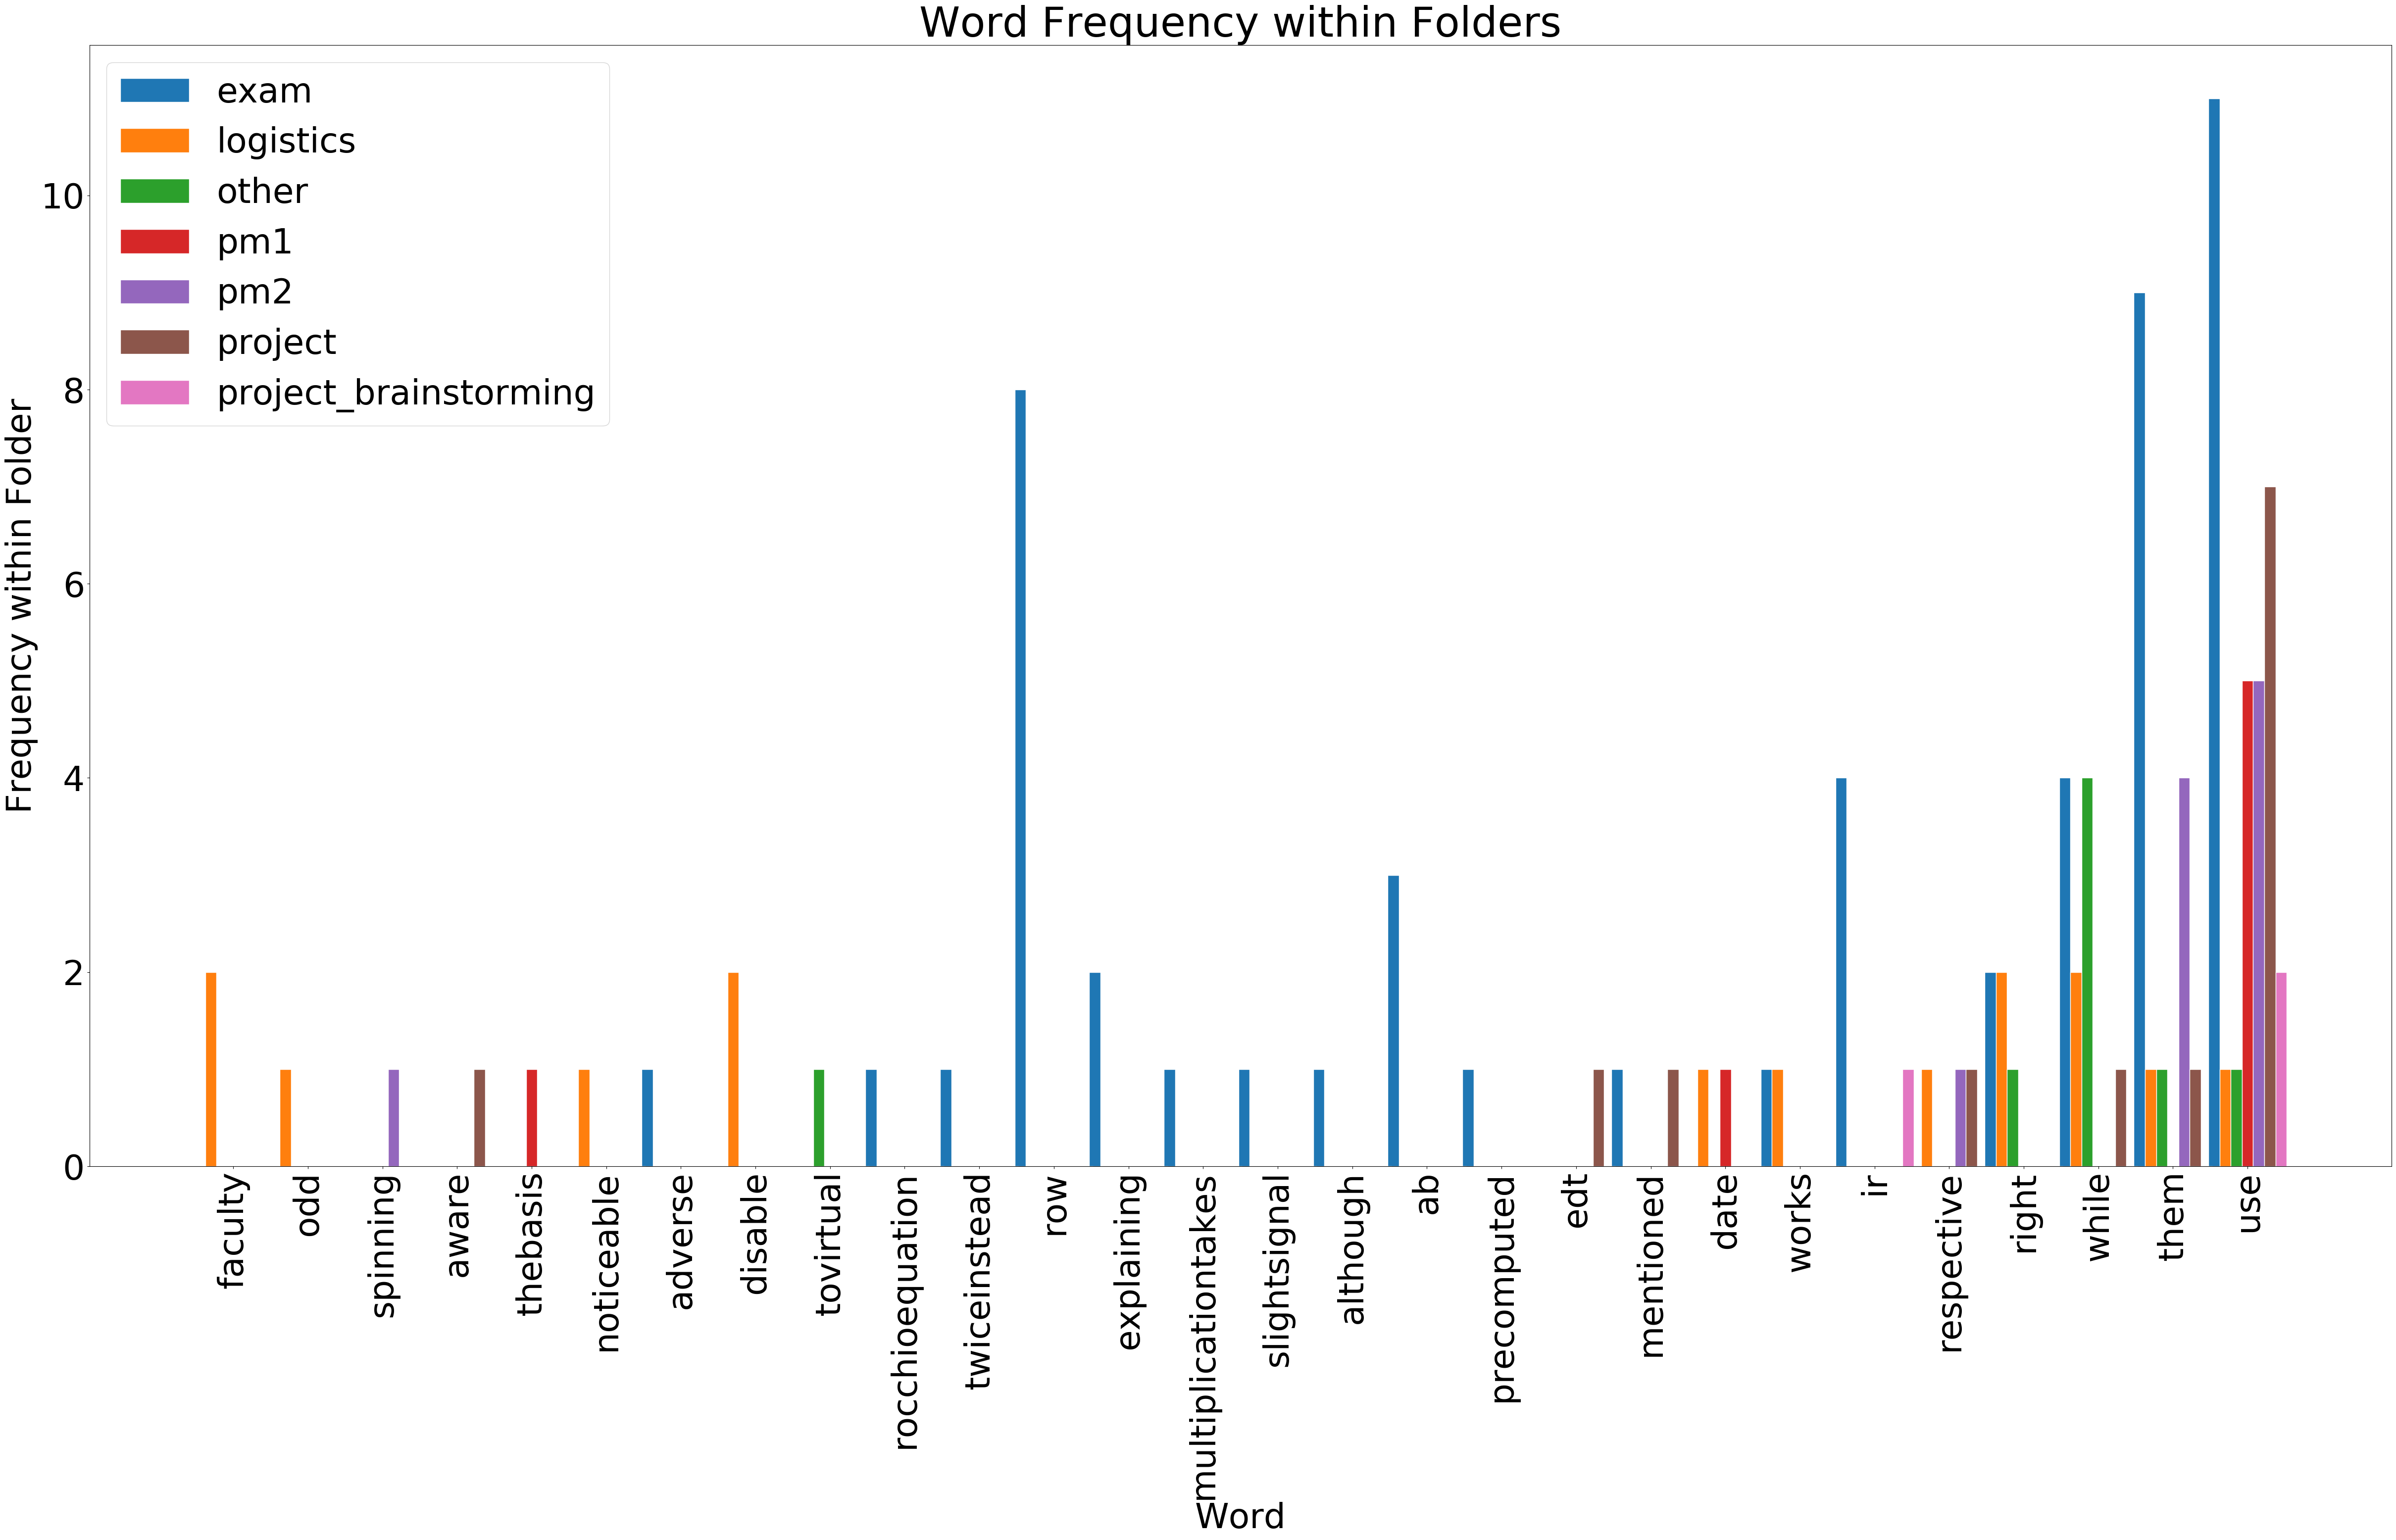

In [44]:
r = np.arange(cst)*2
# Make the plot
for idx, (tag, bars) in enumerate(heights.items()):
    curr_x = [x + idx * barWidth for x in r]
    plt.bar(curr_x, bars, width=barWidth, edgecolor='white', label=tag)
    
print(curr_x)
 
# Add xticks on the middle of the group bars
plt.xlabel('Word')
plt.xticks([2*r + (barWidth * (len(folders) - 1) / 2) for r in range(len(curr_x))], key_order, rotation=90)
 
# Create legend & Show graphic
plt.legend()
plt.ylabel("Frequency within Folder")
plt.title("Word Frequency within Folders")
plt.plot()
plt.savefig("sample_tag_word_freq.png")